In [3]:
import numpy as np
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import MultiTaskElasticNetCV



$\textbf{Introduction}$

In this section I want to show how the Elastic Net with Cross Validation ruthlessly kills off meaningless coefficients or nuisance parameters in a regression equation.

I will use a VAR to start, all random controls with five state variables, with four lags, and five controls.
Naturally all of the coefficients should be zero.  These are just random variables.  But of course, they come out with non-zero values in any regression.  

We can get rid of them by T-statistics.  But that is old frequentist way of thinking.  We can use modern Machine Learning with the Elstic Net and Cross Validation to get rid of thes nuisance parameters, or vampires.

The Elastic Net has the following representation:

$
{\beta}_{\text{Elastic Net}} = \arg\min_{\beta} \left\{\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}\right)^2 + \lambda \left[\alpha \sum_{j=1}^{p} |\beta_j| + (1-\alpha) \sum_{j=1}^{p} \beta_j^2\right]\right\}
$




The parameters $\lambda, \alpha$ are the regularization parameters.  The parameter $\alpha$ controls the weight on the sum of squares of the estimated parameters relative to the sum of absolute values of the estimated parameters.  With $\alpha$ = 1 we have Least Absolute Selection operator (LASSO) while $\alpha$= 0 reduces to Ridge Regression.  With 0<$\alpha$<1, we have Elastic Net.  

The parameter $\alpha$ if often referred to as the L1 regularization parameter,  with L1=0 implying Ridge Regression and L1=1 LASSO.

I usually fixed $\alpha$ = 1 and let Cross Validation find the best value for $\lambda$.

$\textbf{Cross Validation}$

Cross-validation (CV) is a technique used in machine learning and statistical modeling to assess the performance of a predictive model, such as the Elastic Net model represented by the equation you provided. It helps in estimating how well the model will generalize to new, unseen data. Here's a quick explanation of cross-validation in the context of the Elastic Net equation:

-  Dataset Splitting: The first step in cross-validation is to split your dataset into two or more subsets. Typically, the dataset is divided into a training set and a validation or testing set. In some cases, a third set called the validation set is used for hyperparameter tuning.

-  Model Training: You train your Elastic Net model on the training set. In the context of the equation, this involves finding the optimal values for the coefficients $\beta_i$ that minimize the given objective function. 

-  For a fixed $\alpha$  this involves adjusting the parameter $\lambda$ to control the parameter sets. 

-  Model Evaluation: After training, you evaluate the model's performance on the validation or testing set. In the context of the equation, this means using the trained $\beta_i$ values to make predictions on the validation/testing data and comparing these predictions to the actual outcomes (labels).


- Performance Metric: You typically use a performance metric, such as Mean Squared Error (MSE), to measure how well the model's predictions align with the actual values. In the context of the equation, this metric would be used to quantify the goodness of fit of the Elastic Net model.

- Repeat and Average: To get a robust estimate of the model's performance, you repeat steps 2-4 multiple times, each time with a different subset of data as the validation/testing set. This is where cross-validation comes into play. 

- Common cross-validation techniques include k-fold cross-validation (splitting the data into k subsets and repeating the process k times) or leave-one-out cross-validation (using each data point as a validation set once).

Model Selection: Finally, you can use the cross-validation results to select the best model, including the choice of hyperparameters $\alpha$ and $\lambda$ 

-  The goal is to find the model that performs well on average across all the validation/testing subsets.

- By using cross-validation, you obtain a more reliable estimate of your model's performance because it assesses how well the model generalizes to different subsets of data. This helps you avoid issues like overfitting (where the model fits the training data too closely but doesn't generalize well) and underfitting (where the model is too simplistic and doesn't capture the underlying patterns).

$\textbf{Artificial Data}$

- In this experiment we generate artificial data for the state variables Y and the controls X, which we set as exogenous variables.

- Note that we normalize the data to lie between zero and one.  This greatly enhances the efficiency of the nonlinear estimation.

- We have 20 variables with four lags plus five controls.   We have a total of 1720 coefficients.  All of them as estimated are non zero.  Trivially so.  We have 1600 coefficients for 80 lags on 20 equations, plus 5 exogenous coefficients on 20 equations plus 20 constant terms. 

- We run the model below with the four lags.  Note that we also normalize the data.  Doing so helps to speed up the nonlinear estimation when we do elastic net.

In [21]:


import numpy as np
import pandas as pd
from statsmodels.tsa.api import VARMAX

# Combine Y and controls into a single DataFrame
np.random.seed(0)
Y = np.random.randn(5000, 20)
np.random.seed(1)
X = np.random.randn(5000, 5)
Ynorm = (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Xnorm =  (X-np.min(X))/(np.max(X)-np.min(X))
#df = pd.DataFrame(Y, columns=['Y1', 'Y2', 'Y3', 'Y4', 'Y5'])
#X = pd.DataFrame(controls, columns=['X1', 'X2', 'X3', 'X4', 'X5'])
df = pd.DataFrame(Ynorm)
XX = pd.DataFrame(Xnorm)
nlags = 4  # You can change this to your desired number of lags

# Create a VARMAX model
model = VAR(df, exog=XX)

# Fit the VARMAX model with the specified number of lags
results = model.fit(maxlags=nlags)  # Reduced maxlags value
print(results.summary())
beta = results.coefs
beta_flattened = beta.flatten()


alpha1 = results.coefs_exog

alpha1_flattened = alpha1.flatten()
con = results.intercept
con_flattened = con.flatten()


num_non_zero_elements_var = np.count_nonzero(beta_flattened)+np.count_nonzero(alpha1_flattened)

# Print the result
print("Number of non-zero elements:", num_non_zero_elements_var)



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Oct, 2023
Time:                     16:35:04
--------------------------------------------------------------------
No. of Equations:         20.0000    BIC:                   -85.8674
Nobs:                     4996.00    HQIC:                  -87.3245
Log likelihood:           80040.6    FPE:                5.41962e-39
AIC:                     -88.1109    Det(Omega_mle):     3.85234e-39
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.517384         0.069452            7.450           0.000
0            -0.003813         0.012885           -0.296           0.767
1            -0.006762         0.012714           -0.532           0.595
2            -0.011612 

$\textbf{Cross Validation Results}$

We do the cross validation estimation.  In this setup the alpha is hte $\lambda$ in the equation and the L1 ratio is the $\alpha$.  The results show that for best out of sample mean squared error, the L1 shold be .9, with more weight on LASSO, and that the penalty factor need only be .0041.  It does not take much to kill off all of the coefficients to zero.  The number of non-zero coefficients left standing is zero. 

In [35]:
lower_alpha_bound = 0.001
upper_alpha_bound = 0.1

df_mean = df.mean()
df_demeaned = df - df_mean

elastic_net_cv = MultiTaskElasticNetCV(cv=TimeSeriesSplit(n_splits=20),
    alphas = np.logspace(np.log10(lower_alpha_bound), np.log10(upper_alpha_bound), num=30),
                                    l1_ratio=[.01, .1, 0.5, 0.9,1])

# Fit the MultiTaskElastic Net model to X with df as the target variable
elastic_net_cv.fit(XX, df_demeaned)

# Count the number of non-zero coefficients
num_non_zero_elements_enet = np.count_nonzero(elastic_net_cv.coef_)

optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_


print('num_non_zero_elements_enet', num_non_zero_elements_enet)
# Print the results
print("Optimal Alpha:", optimal_alpha)
print("Optimal L1 Ratio:", optimal_l1_ratio)
num_equations = 20  # Number of equations (Y variables)
num_exog_variables = XX.shape[1] - num_equations  # Number of exogenous variables
# Coefficients for lagged Y variables (VAR coefficients)




C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

num_non_zero_elements_enet 0
Optimal Alpha: 0.0041753189365604
Optimal L1 Ratio: 0.9


In [39]:
var_coefficients = elastic_net_cv.coef_[:num_equations, :num_equations * nlags]
exog_coefficients = elastic_net_cv.coef_[:num_equations,:num_equations * nlags:]
constant_term = elastic_net_cv.intercept_
final_mse = elastic_net_cv.mse_path_.mean(axis=1)[-1]

print("Final Mean Squared Error (MSE):", final_mse)

Final Mean Squared Error (MSE): [0.01188156 0.01216944 0.01164851 0.01214074 0.01199566 0.01231737
 0.01219493 0.01191838 0.01224494 0.01216874 0.01220306 0.01180946
 0.0116463  0.01229543 0.01186203 0.01211759 0.01214987 0.01211282
 0.01221401 0.01198027]


$\textbf{Application to Dow Jones Stock Prices}$

- We now do the same analysis for forecasting the daily returns on the Dow Jones with the VAR and EN-CV.  
- Theoretically share price returns should follow a random walking in a world of efficient information.  
- So all of the coefficients should be zero.  
- But when we estimate with a VAR, of course, we get nuisance parameters.  Let's see if the EN does the same job as above.



In [50]:
import yfinance as yf
import pandas as pd

# Define the tickers for Dow Jones 30 stocks
dow_tickers = ["AAPL", "MSFT", "GS", "JPM", "V", "PG", "IBM", "HD", "CRM", "DIS", "NKE", "MCD", "UNH", "AMGN", "CAT",
               "TRV", "HON", "CSCO", "WBA", "MMM", "CVX", "WMT", "VZ", "AXP", "BA", "KO", "MRK", "INTC", "AAP"]

# Define the ticker for VIX (Volatility Index)
vix_ticker = "^VIX"

# Define the ticker for the Fed Funds Rate (e.g., 10-year Treasury yield)
fed_funds_ticker = "^IRX"

# Define the date range for historical data
start_date = "2005-01-01"
end_date = "2022-12-31"

# Download historical data
dow_data = yf.download(dow_tickers, start=start_date, end=end_date)
vix_data = yf.download(vix_ticker, start=start_date, end=end_date)
fed_funds_data = yf.download(fed_funds_ticker, start=start_date, end=end_date)

# Extract adjusted closing prices for Dow Jones 30 stocks, VIX, and Fed Funds rate
dow_prices = dow_data['Adj Close']
vix_prices = vix_data['Adj Close']
fed_funds_rate = fed_funds_data['Adj Close']

# Create separate DataFrames for each set of data
dow_prices.columns = dow_tickers  # Rename columns to match tickers
vix_prices.columns = ["VIX"]
fed_funds_rate.columns = ["Fed Funds Rate"]

# Merge DataFrames using the date index
data = pd.concat([dow_prices, vix_prices, fed_funds_rate], axis=1)
data = data.dropna(axis=1)

# Save the data to a CSV file
#data.to_csv("stock_data.csv")

# Print a sample of the data
print(data.head())
print(data.shape)



[*********************100%***********************]  29 of 29 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 AAPL      MSFT         GS        JPM          V         PG  \
Date                                                                          
2005-01-03  25.633396  0.959292  46.936638  36.735241  35.678844  29.279112   
2005-01-04  25.462700  0.969144  46.191845  36.183315  34.985836  28.955761   
2005-01-05  25.509792  0.977632  45.461647  35.847488  35.566837  28.401407   
2005-01-06  25.486235  0.978390  45.885162  35.663120  35.335850  28.820246   
2005-01-07  25.339098  1.049628  45.980083  35.399742  35.216843  28.758648   

               IBM         HD        CRM        DIS  ...        MMM  \
Date                                                 ...              
2005-01-03  4.1500  13.311672  25.246532  22.612062  ...  15.047479   
2005-01-04  4.0900  12.7

In [83]:

import numpy as np

# Specify the number of columns you want to include in Y
num_columns = 29

# Take the log first difference of the selected columns
Y = data.iloc[:, :num_columns].apply(lambda x: np.log(x).diff())

# Drop the first row (NaN values resulting from the difference operation)
Y = Y.dropna()

# Print a sample of the Y DataFrame
print(Y.head())
Y = Y.dropna()








                AAPL      MSFT        GS       JPM         V        PG  \
Date                                                                     
2005-01-04 -0.006681  0.010218 -0.015995 -0.015138 -0.019615 -0.011105   
2005-01-05  0.001848  0.008720 -0.015934 -0.009325  0.016470 -0.019330   
2005-01-06 -0.000924  0.000775  0.009273 -0.005156 -0.006516  0.014639   
2005-01-07 -0.005790  0.070283  0.002067 -0.007413 -0.003374 -0.002140   
2005-01-10  0.003478 -0.004196  0.010584  0.002044  0.013229 -0.009252   

                 IBM        HD       CRM       DIS  ...       MMM       CVX  \
Date                                                ...                       
2005-01-04 -0.014563 -0.040132 -0.006900 -0.010830  ... -0.004168  0.003733   
2005-01-05  0.092751  0.000539  0.006507 -0.005460  ...  0.006724 -0.002238   
2005-01-06 -0.012896  0.014965  0.016567  0.001459  ...  0.006995 -0.001121   
2005-01-07 -0.009640 -0.006920 -0.011276 -0.009888  ... -0.013718 -0.002995   
2005-01

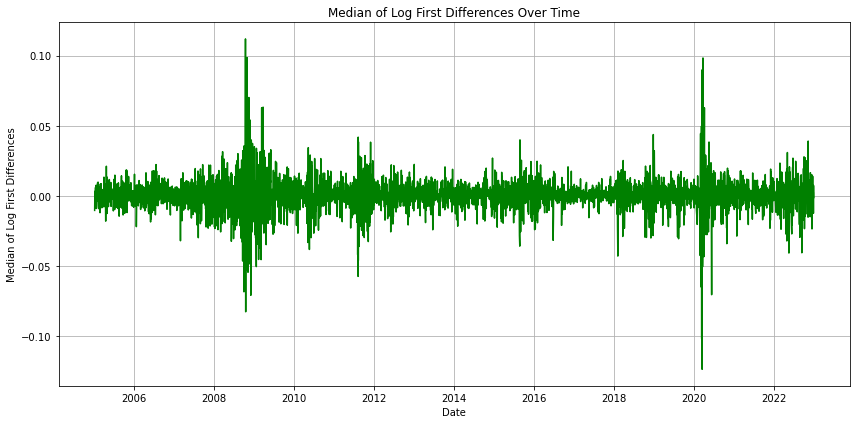

In [84]:

import matplotlib.pyplot as plt

# Plot the median of each column in Y
plt.figure(figsize=(12, 6))
Y_median = Y.median(axis=1)
plt.plot(Y_median.index, Y_median.values, label='Median', color='green')

# Set the x-axis labels to be the index (dates) of Y
plt.xlabel('Date')
plt.ylabel('Median of Log First Differences')
plt.title('Median of Log First Differences Over Time')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()











In [87]:

# Specify the number of columns you want to include in Y

# Extract the 'Fed Funds Rate' and 'VIX' columns from separate DataFrames
X = pd.concat([fed_funds_rate, vix_prices], axis=1)

# Rename the columns if needed
X.columns = ["Fed Funds Rate", "VIX"]

# Print a sample of the X DataFrame
print(X.head())


            Fed Funds Rate    VIX
Date                             
2005-01-03           2.204  14.08
2005-01-04           2.292  13.98
2005-01-05           2.282  14.09
2005-01-06           2.267  13.58
2005-01-07           2.277  13.49


In [88]:
print(X.shape)
print(Y.shape)

(4531, 2)
(4530, 29)


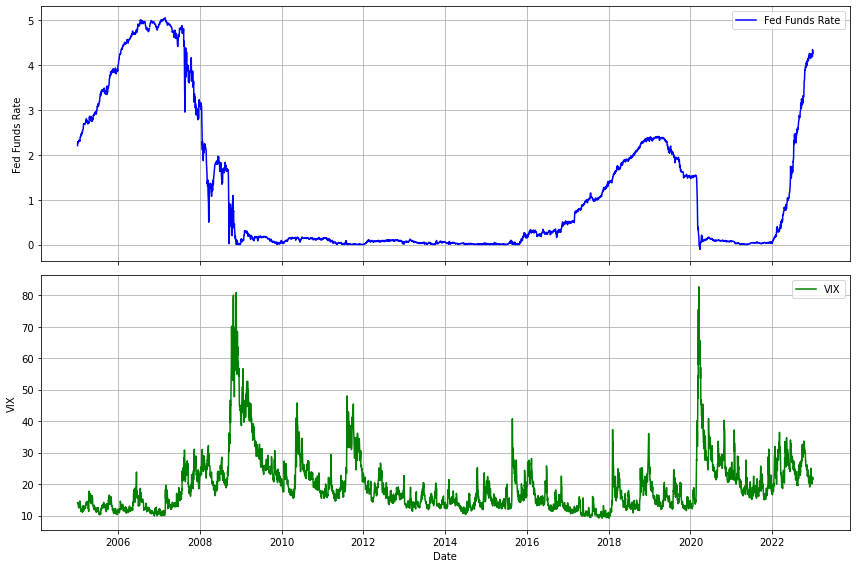

In [90]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the 'Fed Funds Rate' on the first subplot
axs[0].plot(X.index, X["Fed Funds Rate"], label='Fed Funds Rate', color='blue')
axs[0].set_ylabel('Fed Funds Rate')
axs[0].grid(True)
axs[0].legend()

# Plot the 'VIX' on the second subplot
axs[1].plot(X.index, X["VIX"], label='VIX', color='green')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('VIX')
axs[1].grid(True)
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [91]:
X = X[1:]

In [98]:
print(len(X))
print(len(Y))
X = X.fillna(method='ffill')
Xnorm = (X-np.min(X))/(np.max(X)-np.min(X))
Ynorm = (Y-np.min(Y))/(np.max(Y)-np.min(Y))

4530
4530


C:\Users\mcnel\AppData\Local\Temp\ipykernel_3696\3198089836.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')


In [107]:
nlags = 5  # You can change this to your desired number of lags

# Create a VARMAX model
model = VAR(Ynorm, exog=Xnorm)

# Fit the VARMAX model with the specified number of lags
results = model.fit(maxlags=nlags)  # Reduced maxlags value
#print(results.summary())
beta1 = results.coefs
beta1_flattened = beta.flatten()


alpha11 = results.coefs_exog


alpha11_flattened = alpha1.flatten()


con = results.intercept
con_flattened = con.flatten()

num_elements = len(alpha11_flattened) + len(beta1_flattened)

num_non_zero_elements_var = np.count_nonzero(beta1_flattened)+np.count_nonzero(alpha11_flattened)

# Print the result
print("Number of elements", num_elements)
print("Number of non-zero elements:", num_non_zero_elements_var)

Number of elements 1720
Number of non-zero elements: 1720


C:\Users\mcnel\anaconda4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [108]:
lower_alpha_bound = 0.001
upper_alpha_bound = 0.1

Ynorm_mean = Ynorm.mean()
Y_demeaned = Ynorm - Ynorm_mean

elastic_net_cv = MultiTaskElasticNetCV(cv=TimeSeriesSplit(n_splits=20),
    alphas = np.logspace(np.log10(lower_alpha_bound), np.log10(upper_alpha_bound), num=30),
                                    l1_ratio=[.01, .1, 0.5, 0.9,1])

# Fit the MultiTaskElastic Net model to X with df as the target variable
elastic_net_cv.fit(Xnorm, Y_demeaned)

# Count the number of non-zero coefficients
num_non_zero_elements_enet = np.count_nonzero(elastic_net_cv.coef_)

optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_


print('num_non_zero_elements_enet', num_non_zero_elements_enet)
# Print the results
print("Optimal Alpha:", optimal_alpha)
print("Optimal L1 Ratio:", optimal_l1_ratio)

C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

num_non_zero_elements_enet 58
Optimal Alpha: 0.0041753189365604
Optimal L1 Ratio: 0.01


In [109]:
Kill_Ratio = 1 - num_non_zero_elements_enet/num_elements
print(Kill_Ratio)

0.9662790697674418


In [110]:
predicted_values = elastic_net_cv.predict(Xnorm)

C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mcnel\anaconda4\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [111]:
print(len(predicted_values))

4530


In [122]:
ERRORS = Ynorm - predicted_values
Sigma =  np.dot(ERRORS.T, ERRORS)
variance=np.diag(Sigma)

In [124]:
print(Sigma.shape)
cRange = len(Sigma)
print(cRange)

(29, 29)
29


In [126]:
numlags = 5
phi=beta1[:cRange*numlags,:]
h = 20
def calA(phi,h):
    A=[np.identity(cRange),phi[0]*np.identity(cRange)]
    for i in range(2,h+1):
        index=min(i,len(phi))
        ai=sum([m*n for m,n in zip(A[-index:],phi[:index])])
        A.append(ai)
    return A
horizon=20
A=calA(phi,horizon)

In [128]:
VD=np.zeros((cRange,cRange))
for i in range(cRange):
    for j in range(cRange):
        VD[i,j]=1/variance[i]*sum([(np.dot(A[l],Sigma)[i,j])**2 for l in range(len(A))])/sum([(np.dot(A[l],np.dot(Sigma,A[l].T))[i,i]) for l in range(len(A))])
VD=VD/VD.sum(1).reshape(-1,1)
print(VD.shape)

(29, 29)


In [129]:
VD1=VD-np.diag(np.diag(VD))
Spillover1=VD1.sum()/VD.sum()
Spillover1 

0.9652831153854468

In [131]:
Outward1=VD1.sum(0)
Inward1=VD1.sum(1)
Net1 = Outward1 - Inward1

In [137]:
column_names = data.columns.tolist()  # Convert to a list

column_names_set = set(data.columns)  # Convert to a set
print(column_names)

['AAPL', 'MSFT', 'GS', 'JPM', 'V', 'PG', 'IBM', 'HD', 'CRM', 'DIS', 'NKE', 'MCD', 'UNH', 'AMGN', 'CAT', 'TRV', 'HON', 'CSCO', 'WBA', 'MMM', 'CVX', 'WMT', 'VZ', 'AXP', 'BA', 'MRK', 'INTC', 'AAP', 'Adj Close']


In [142]:
names1 = column_names[:10]
names2 = column_names[10:20]
names3 = column_names[20:]

In [143]:
print(names3)

['CVX', 'WMT', 'VZ', 'AXP', 'BA', 'MRK', 'INTC', 'AAP', 'Adj Close']


Text(0.5, 0.98, 'Net Connectedness of Dow-Jones Listed Returns: Elastic Net Estimation')

<Figure size 4500x6000 with 0 Axes>

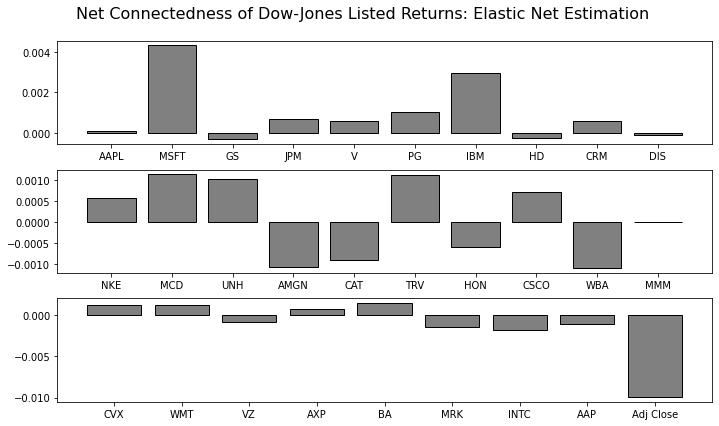

In [152]:
plt.figure(figsize=(15,20),dpi=300)
fig1,(ax11,ax12,ax13)=plt.subplots(3,1,figsize=(10,6))
#mpl.rcParams.update({'font.size': 12})
ax11.bar(names1,Net1[:10],color=['gray'],edgecolor="black",label='Active')
ax12.bar(names2,Net1[10:20],color=['gray'],edgecolor="black",label='Active')
ax13.bar(names3,Net1[20:],color=['gray'],edgecolor="black",label='Active')
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin
plt.suptitle('Net Connectedness of Dow-Jones Listed Returns: Elastic Net Estimation', fontsize=16)
#plt.savefig('full_net.jpg',dpi=300)